In [125]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from statsmodels.tsa import stattools
from statsmodels.tsa import seasonal

In [2]:
## Load dataset

train = pd.read_csv('./Datasets/train_fwYjLYX.csv', parse_dates=['application_date'])

In [3]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null datetime64[ns]
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.7+ MB


In [5]:
train['application_date'].min(), train['application_date'].max()

(Timestamp('2017-04-01 00:00:00'), Timestamp('2019-07-23 00:00:00'))

In [6]:
train['segment'].value_counts()

1    66898
2    13504
Name: segment, dtype: int64

In [7]:
train_segment1 = train[train['segment'] == 1]

In [8]:
train_segment1.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [9]:
train_segment1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66898 entries, 0 to 66897
Data columns (total 6 columns):
application_date    66898 non-null datetime64[ns]
segment             66898 non-null int64
branch_id           66898 non-null float64
state               66898 non-null object
zone                66898 non-null object
case_count          66898 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.6+ MB


In [10]:
train_segment1 = train_segment1.set_index('application_date')

In [11]:
train_segment1.head()

,segment,branch_id,state,zone,case_count
application_date,,,,,
2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [12]:
train_segment1.index.min(), train_segment1.index.max()

(Timestamp('2017-04-01 00:00:00'), Timestamp('2019-07-05 00:00:00'))

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [110]:
## Calculate the proportion of zeros
train_segment1[train_segment1['case_count'] == 0.0]

,segment,branch_id,state,zone,case_count
application_date,,,,,
2017-05-08,1,1.0,WEST BENGAL,EAST,0.0
2017-06-01,1,1.0,WEST BENGAL,EAST,0.0
2017-07-02,1,1.0,WEST BENGAL,EAST,0.0
2017-08-04,1,1.0,WEST BENGAL,EAST,0.0
2017-08-06,1,1.0,WEST BENGAL,EAST,0.0
...,...,...,...,...,...
2019-06-14,1,271.0,HARYANA,NORTH,0.0
2019-06-16,1,271.0,HARYANA,NORTH,0.0
2019-06-23,1,271.0,HARYANA,NORTH,0.0


In [89]:
offers_average = train_segment1['case_count'].resample('MS').mean()

In [90]:
offers_average

application_date
2017-04-01    16.762048
2017-05-01    16.388353
2017-06-01    23.225301
2017-07-01    20.183400
2017-08-01    24.411647
2017-09-01    44.286376
2017-10-01    35.430237
2017-11-01    17.852610
2017-12-01    26.466770
2018-01-01    26.334940
2018-02-01    27.898706
2018-03-01    41.722892
2018-04-01    24.909639
2018-05-01    28.106879
2018-06-01    35.850602
2018-07-01    32.878741
2018-08-01    36.173727
2018-09-01    35.622892
2018-10-01    58.825884
2018-11-01    53.140964
2018-12-01    32.760591
2019-01-01    36.616401
2019-02-01    35.135112
2019-03-01    36.771473
2019-04-01    35.595582
2019-05-01    36.097163
2019-06-01    39.076707
2019-07-01    35.997590
Freq: MS, Name: case_count, dtype: float64

## Autocorrelation

In [91]:
sns.set_style('darkgrid')

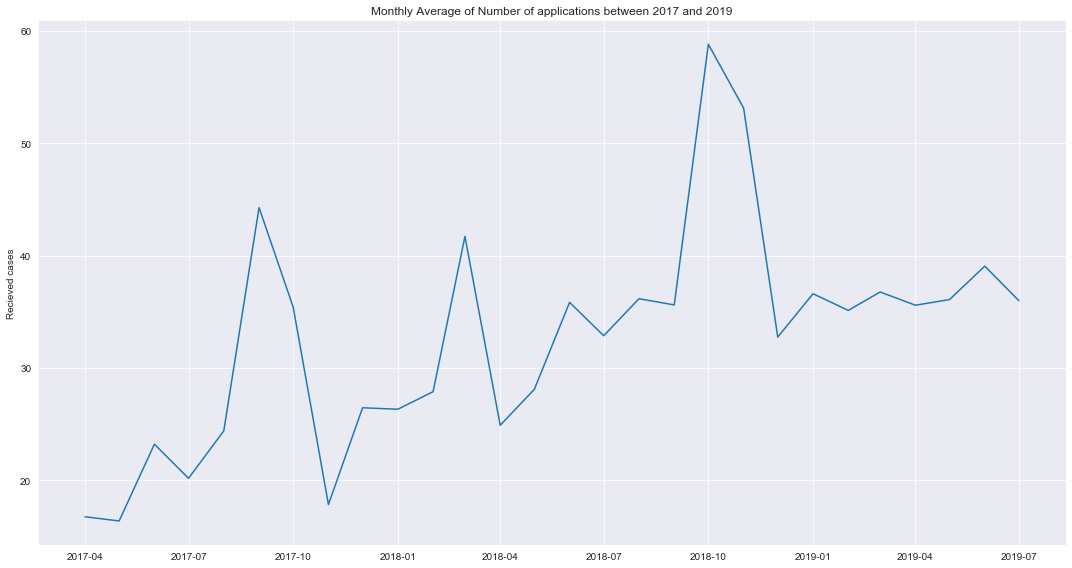

In [92]:
plt.figure(figsize=(15,8))
plt.plot(offers_average)
plt.title('Monthly Average of Number of applications between 2017 and 2019')
plt.ylabel('Recieved cases')
plt.tight_layout()
plt.show()

In [93]:
lag = range(0,25)
offers_average_acf = []
for l in lag:
    offers_average_acf.append(offers_average.autocorr(l))

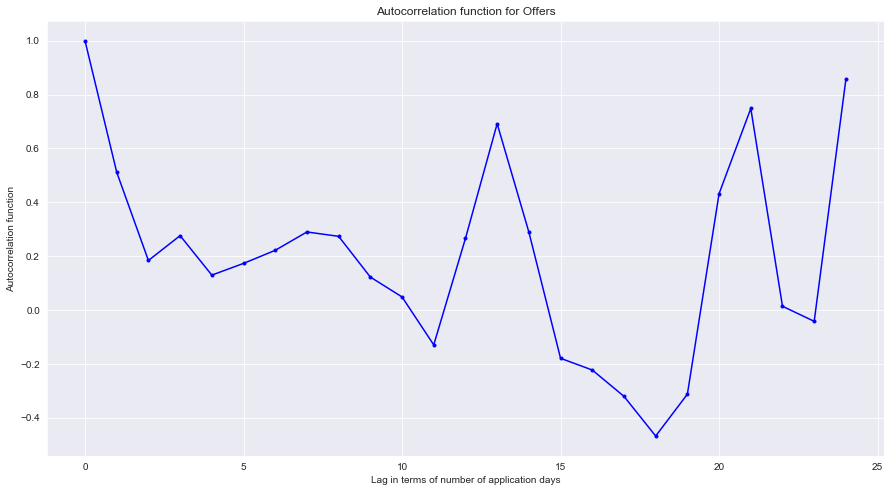

In [94]:
plt.figure(figsize=(15, 8))
plt.plot(offers_average_acf, marker='.', color='b')
plt.title('Autocorrelation function for Offers')
plt.xlabel('Lag in terms of number of application days')
plt.ylabel('Autocorrelation function')
plt.show()

<Figure size 396x396 with 0 Axes>

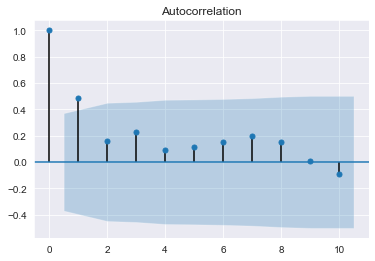

In [95]:
#Plot autocorrelation and confidence intervals using the plot_acf function
plt.figure(figsize=(5.5, 5.5))
plot_acf(offers_average, lags=10)
plt.show()

<Figure size 396x396 with 0 Axes>

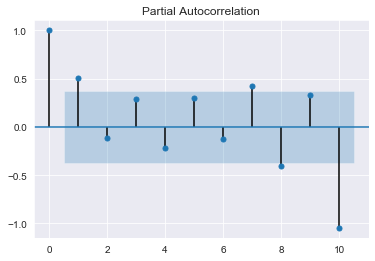

In [97]:
#Plot partial autocorrelation and confidence intervals using the plot_acf function
plt.figure(figsize=(5.5, 5.5))
plot_pacf(offers_average, lags=10)
plt.show()

## Augmented Dickey Fuller Test

In [98]:
#Check for missing values and remove the row
missing = pd.isnull(train_segment1['case_count'])
print('Number of missing values found:', missing.sum())

Number of missing values found: 0


In [100]:
adf_result = stattools.adfuller(train_segment1['case_count'], autolag='AIC')
print('p-val of the ADF test in application recieved: %f' % adf_result[1])

p-val of the ADF test in application recieved: 0.0000


In [101]:
adf_result[0]

-8.817435628591902

This series is non-stationary

## Visualizing Moving Averages

In [102]:
weekly_moving_average = train_segment1['case_count'].rolling(7).mean()
monthly_moving_average = train_segment1['case_count'].rolling(30).mean()

Text(0.5, 1.0, 'Monthly moving averages')

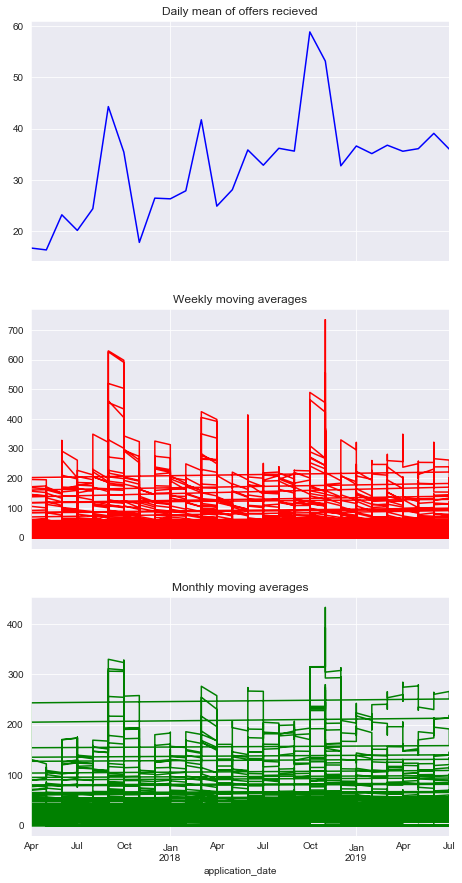

In [119]:
#Plot original time series and weekly moving average
fig, axarr = plt.subplots(3, sharex=True)
fig.set_size_inches(7.5, 15,8)

daily_mean = train_segment1['case_count'].mean()
offers_average.plot(ax=axarr[0], color='b')
axarr[0].set_title("Daily mean of offers recieved")

weekly_moving_average.plot(ax=axarr[1], color='r')
axarr[1].set_title("Weekly moving averages")

monthly_moving_average.plot(ax=axarr[2], color='g')
axarr[2].set_title('Monthly moving averages')

In [120]:
train_segment1['case_count'].min(), train_segment1['case_count'].max()

(0.0, 1890.0)

## Seasonal Decomposition

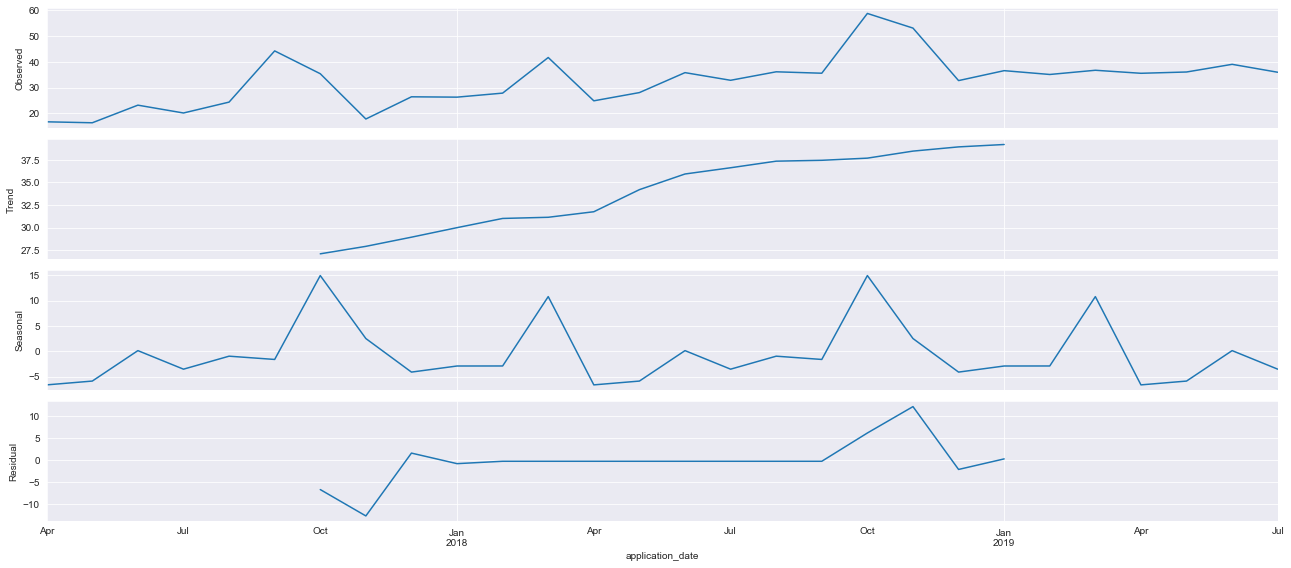

In [123]:
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal.seasonal_decompose(offers_average, model='additive')
fig = decomposition.plot()
plt.show()